In [69]:
import pandas as pd
import numpy as np


First Step: PreProcess the Data
1. We want all rows to represent one observation or one instance (e.x. data for one county in one year). We also want all columns to represent one feature, which is one type of information about the observation. For this, we used pivot_wide property of pandas in the AllData.ipynb file. 
2. Non-Numeric to Numeric Conversion: Columns that were previously objects (because of "N/A" strings) are now showing as float64, which means they have been succesfully converted to numeric. THis is important for numerical analysis and understanding. 
3. Handling Missing Values: The missing values are now represented NaN (Not a Number), which will be handled appropriately by Pandas and the ML libraries
4. Data Summary using describe() to show column statistics, .dtypes() to confirm that all columns are of the correct data type, and nunique() to make sure each column's data has been succesfully read

In [70]:

values_data = pd.read_csv("pivot_wide_format_data.csv")

#Replace all NaN values with "N/A"
values_data.fillna("N/A", inplace=True)

values_data.replace("N/A", np.nan, inplace=True)

# List of column pairs to merge
column_pairs = [
    ('Child Mortality Rate (White)', 'Child Mortality Rate (white)'),
    ('Drug Overdose Mortality Rate (White)', 'Drug Overdose Mortality Rate (white)'),
    ('Firearm Fatalities Rate (White)', 'Firearm Fatalities Rate (white)'),
    ('Homicide Rate (White)', 'Homicide Rate (white)'),
    ('Infant Mortality Rate (White)', 'Infant Mortality Rate (white)'),
    ('Injury Death Rate (White)', 'Injury Death Rate (white)'),
    ('MV Mortality Rate (White)', 'MV Mortality Rate (white)'),
    ('Suicide Rate (White)', 'Suicide Rate (white)'),
    ('Teen Birth Rate (White)', 'Teen Birth Rate (white)'),
    ('YPLL Rate (White)', 'YPLL Rate (white)'),
    ('Preventable Hospitalization Rate', 'Preventable Hosp. Rate')
]

for pair in column_pairs:
    column1, column2 = pair
    # Combine the columns and prioritize the non-null values in the first column
    values_data[column1] = values_data[column1].combine_first(values_data[column2])
    # Drop the second column as its data has been merged
    values_data.drop(column2, axis=1, inplace=True)

#Convert object columns that should be numeric to float
for column in values_data.columns:
    if values_data[column].dtype == "object" and column not in ["County", "Year"]:
        values_data[column] = pd.to_numeric(values_data[column], errors="coerce")
values_data.to_csv("pivot_wide_format_data_cleaned.csv", index=False)



/var/folders/dr/13q6jns56rldkk1nfqpc25240000gn/T/ipykernel_14308/3830620394.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'N/A' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  values_data.fillna("N/A", inplace=True)


In [71]:
print(values_data.head())

print(values_data.dtypes)

print(values_data.describe())

print(values_data.nunique())


    County  Year  % Adults with Obesity  % Children in Poverty  \
0  Appling  2011                    NaN                   31.3   
1  Appling  2012                    NaN                   35.7   
2  Appling  2013                    NaN                   34.0   
3  Appling  2014                    NaN                   34.8   
4  Appling  2015                    NaN                   40.3   

   % Excessive Drinking  % Smokers  % Unemployed  % Uninsured  ACSC Rate  \
0                  13.2       23.0           NaN    24.600000        NaN   
1                  11.0       20.2     10.700000    23.700000        NaN   
2                   9.6       24.8     11.000000    24.900000        NaN   
3                   NaN       27.8     10.317788    25.189603        NaN   
4                   NaN       27.8     10.023661    24.231524        NaN   

   Age-Adjusted Death Rate  ...  Teen Birth Rate (Black)  \
0                      NaN  ...                      NaN   
1                      NaN

Second Step: Data Scaling
Scale the numerical data to ensure that all features contribute equally to the distance calculation in the clustering algorithm. Without scaling, features with larger ranges could influence the model more than features with smaller ranges. Scaling prevents this by ensuring that each feature has a similar influence on the model. 

For K-Means Clustering, we will be using standardization (Z-Score normalization) since K-Means is a distance-based algorithm and standardization maintains the effect of outliers in the data. In standardization, the features are rescaled so that they have properties of a standard normal distribution with a mean of 0 and standard deviation from the mean of 1. Standardization can be calculated as X - mean / (standard deviations from mean) where X represents the original value of the feature. In Pandas, we will use 'StandardScaler' from the 'sklearn.preprocessing' library

Some other data scaling techniques include min-max scaling (getting all values between given range) and robust scaling (uses the median and interquartile range or IQR so its robust to outliers)

In [72]:

from sklearn.preprocessing import StandardScaler
import pandas as pd 

#1. Seperate Features from Identifiers (County and Year). We don't want to scale identifier columns
identifiers = values_data[['County', 'Year']]
features = values_data.drop(['County', 'Year'], axis=1)

#2. Initialize Standard Scaler 
scaler = StandardScaler()

#3. Fit and transform the scaler on the features
scaled_features = scaler.fit_transform(features)

#The output of Standard Scaler is a NumPy array, so convert it back to a Data Frame 
scaled_features_df = pd.DataFrame(scaled_features, columns=features.columns)

#Combine the scaled features with the identifiers
data_scaled = pd.concat([identifiers, scaled_features_df], axis=1)

#Save the scaled data to a csv 
data_scaled.to_csv("pivot_wide_format_data_scaled.csv", index=False)
 

Step 3: K-Means Clustering Overview
K-Means is a centroid-based algorithm that aims to partition the dataset into k clusters in which each observation belongs to the cluster with the nearest mean. The steps typically involved in k-means clustering are (1) Initialization: choose k initial centroids (either randomly or based on some data-driven heuristic) (2) Assignment: Assign each observation to the cluster with the nearest centroid. (3) Update: Recalulcate the centroids as the mean of all observations assigned to each cluster. (4) Iteration: Repeat the assignment and update steps until the centroids do not change significantly or a maximum number of iterations is reached. 

In [73]:
#1. Apply the elbow method to determine the optimal number of clusters. The elbow method works by running the K-means 
# clustering on the dataset for a range of values (k=1 through 10), and for each value of K, you calculate the sum of 
# squared distances from each point to its assigned center. When you plot these values, the "elbow" is considered to be 
# an indicator of the appropriate number of clusters. The intuition behind the elbow method is that increasing the number
# of clusters will naturally improve the fit (explain more of the variation), since there are more parameters (cluster)
# to use, but at some point, there is overfitting, and the elbow reflects this. 

# Approach: Try each possiblity to see which gives the best values. Imputing NaN with mean. Removing
# NaN entirely. Going with DBSCAN

In [110]:
from sklearn.impute import SimpleImputer 

identifiers = values_data[['County', 'Year']]
features = values_data.drop(['County', 'Year'], axis=1)

# Calculate the percentage of NaN values in each column
nan_percentage = features.isna().mean() * 100


# Identify columns with more than a certain percentage of NaN values (e.g., more than 50%)
threshold = 30  # You can change the threshold as needed

# Drop these columns from the DataFrame
data_cleaned = features.loc[:, nan_percentage <= threshold]


#Strategy 1: Impute Missing Values with the Mean
imputer_mean = SimpleImputer(strategy='mean')

#Apply imputation to the filtered data
data_imputed_mean = pd.DataFrame(imputer_mean.fit_transform(data_cleaned), columns=data_cleaned.columns)
values_data_imputed = pd.concat([identifiers.reset_index(drop=True), data_imputed_mean.reset_index(drop=True)], axis=1)

#Strategy 2: Drop Missing Values 
data_dropped_na = data_cleaned.dropna()
values_data_dropped = pd.concat([identifiers.reset_index(drop=True), data_imputed_mean.reset_index(drop=True)], axis=1)

% Adults with Obesity                69.230769
% Children in Poverty                 0.000000
% Excessive Drinking                 14.997581
% Smokers                            12.191582
% Unemployed                          7.692308
                                       ...    
YPLL Rate (Asian)                    98.500242
YPLL Rate (Black)                    79.777455
YPLL Rate (Hispanic)                 95.162071
YPLL Rate (White)                    79.729076
Years of Potential Life Lost Rate    32.801161
Length: 75, dtype: float64


Imputed Data


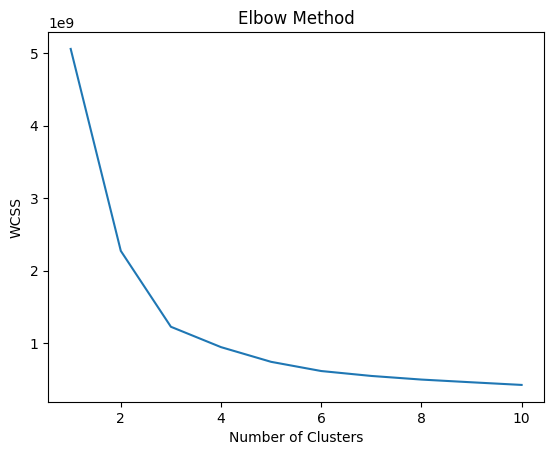

Dropped Data


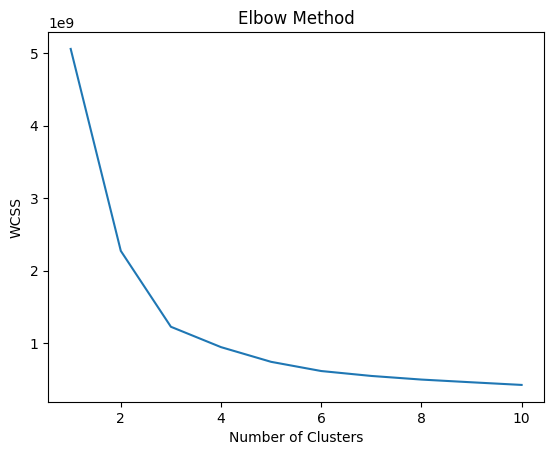

In [75]:
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt

def apply_elbow_method(scaled_data):
    wcss = [] #Within cluster sum of squares 
    for i in range(1,11): #Trying different numbers of clusters
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(scaled_data.drop(['County', 'Year'], axis=1)) #Fit the scaled data
        wcss.append(kmeans.inertia_) # Append the within-cluster sum of squares 

    # Plot the elbow graph 
    plt.plot(range(1,11), wcss)
    plt.title("Elbow Method")
    plt.xlabel("Number of Clusters")
    plt.ylabel("WCSS")
    plt.show()

#1. Mean Imputed Data
print("Imputed Data")
apply_elbow_method(values_data_imputed)

print("Dropped Data")
apply_elbow_method(values_data_dropped)

In [76]:
# 2. Find the point where the decrease in WCSS begins to level off, indicating that adding more clusters does not
# provide better modeling of the data In our graphs, this point is not very pronounced. We can try a couple of 
# cluster values as potential candidates for K. For more precision, you might use other methods such as 
# silhoutte coefficient to validate consistency within clusters 


In [94]:
# Run K-Means Cluster

from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score

# Number of Clusters
n_clusters = 3

#Initialize the K-Means 
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=1000, n_init=10, random_state=10)

# Fit the model to the scaled data (choose the correct DataFrame for your data)
cluster_labels = kmeans.fit_predict(data_imputed_mean)

#Calculate the silhoutte score
#The silhoutte score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters
# (separation). Value ranges from -1 to 1 where higher values designate that an object is well matched to its own 
# cluster and badly matched to others. 
silhoutte_avg = silhouette_score(data_imputed_mean, cluster_labels)
print("The average silhoutte score is: ",silhoutte_avg)

The average silhoutte score is:  0.4817777441300333


In [93]:
# # Run K-Means Cluster

# from sklearn.cluster import KMeans 
# from sklearn.metrics import silhouette_score

# # Number of Clusters
# n_clusters = 3

# #Initialize the K-Means 
# kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=1000, n_init=10, random_state=10)

# # Fit the model to the scaled data (choose the correct DataFrame for your data)
# cluster_labels = kmeans.fit_predict(data_dropped_na)

# #Calculate the silhoutte score
# silhoutte_avg = silhouette_score(data_dropped_na, cluster_labels)
# print("The average silhoutte score is: ",silhoutte_avg)

The average silhoutte score is:  0.4342293178141904


In [119]:
# Assume 'cluster_labels' is the array of cluster labels from you k-means fitting 
# Add the cluster variables to the original data frame with identifiers

values_data_imputed['Cluster'] = cluster_labels

values_data_imputed.to_csv("values_data_imputed.csv", index=False)


sample_clusters = values_data_imputed[['County', 'Year', 'Cluster']].head(10) 

print(sample_clusters)


# Add new chunk - make a plot where we have cluster_id on x axis and one of the variables used for clustering
# on the y-axis and we can plot that as boxplots. 

    County  Year  Cluster
0  Appling  2011        0
1  Appling  2012        2
2  Appling  2013        0
3  Appling  2014        0
4  Appling  2015        0
5  Appling  2016        0
6  Appling  2017        0
7  Appling  2018        0
8  Appling  2019        0
9  Appling  2020        0


ValueError: List of boxplot statistics and `positions` values must have same the length

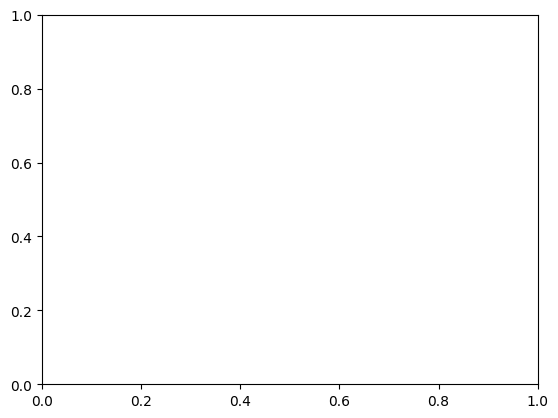

In [118]:
#print(values_data_imputed)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#print(len(values_data_imputed['Cluster']))
#print(len(values_data_imputed['% Adults with Obesity']))
#plt.boxplot(values_data_imputed["% Adults with Obesity"], positions=values_data_imputed['Cluster'])




Step 4: Creating GA Counties Map Showing Cluster Membership

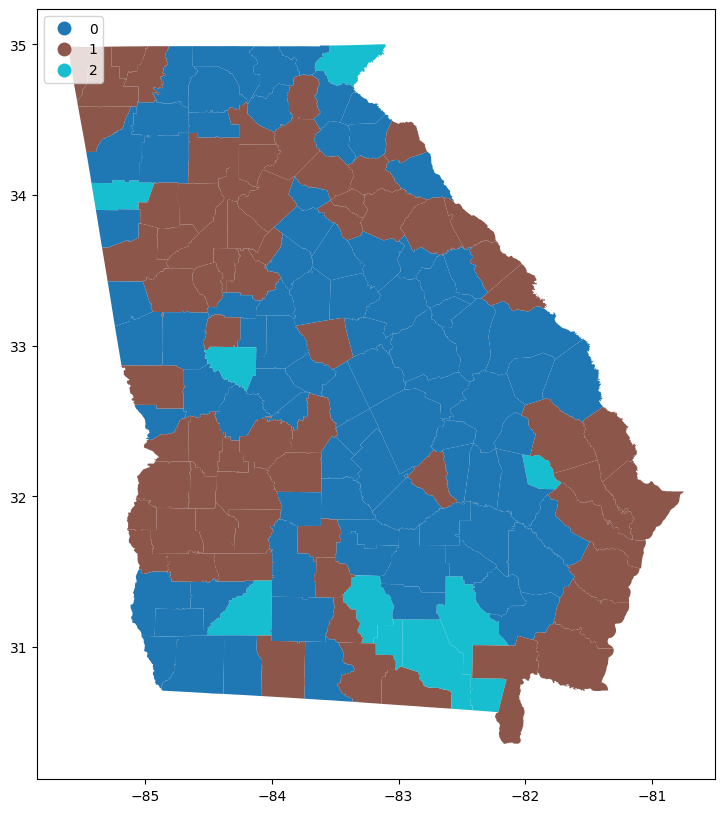

In [108]:
import geopandas as gpd
import matplotlib.pyplot as plt

#Load the shapefile for Georgia Counties
geo_data = gpd.read_file('./Counties_Georgia/Counties_Georgia.shp')


# Filter your clustering results for the year 2022
specific_year_data = values_data_imputed[values_data_imputed['Year'] == 2022]

# Join the geographical data with the cluster data
merged_data = geo_data.set_index('NAME10').join(specific_year_data.set_index('County'))

#print(merged_data['Year'])

# Plotting the map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_data.plot(column='Cluster', ax=ax, legend=True, categorical=True, legend_kwds={'loc': 'upper left'})
plt.show()

